# 1. Word Importance Model for Predicting Importance of Words in Captions
 
     Paper Title: A Corpus for Modeling Word Importance in Spoken Dialogue Transcripts
        https://arxiv.org/pdf/1801.09746.pdf

    Corpus: The Switchboard corpus consists of audio recordings of approximately 260 hours of speech consisting of about 2,400 two-sided telephone conversations among 543 speakers (302 male, 241 female) from across the United States. In January 2003, the Institute for Signal and Information Processing (ISIP) released written transcripts for the entire corpus, which consists of nearly 400,000 conversational turns. The ISIP transcripts include a complete lexicon list and automatic word alignment timing corresponding to the original audio files
    
    The importance score ranges from 0 to 1. However, the paper, referred above, have categorized the words based on the importance level as follows:
        
    Importance Distribution:
    Importance 1: [0-0.1) 
    Importance 2: [0.1-0.3) 
    Importance 3: [0.3-0.5) 
    Importance 4: [0.5-0.7) 
    Importance 5: [0.7-0.9) 
    Importance 6: [0.9-1] 

    The higher the imporance value is, the higher the weight of the word.

    Unsupervised Learning Approaches:
    1. Bag-of-Words
    2. Term frequency and Inverse Document Frequency
    3. Word Embedding(CBOW) Summerization with interpolation of POS importance
    4. Composition of Contextualized Word Embedding (BERT)
    
    Supervised Learning Approaches:
    Note: Contextualized Word Embeddings (BERT) as feature
    1. Logistic Regression
    2. Random Forest Classifier
    
    Existing Best Performing Prior Work:
    Neural Network-based approach(LSTM)

# 2. Importing Libraries

In [1]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import string
import numpy as np
import random
import heapq
import gensim
from gensim.models import Word2Vec
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

# Load pre-trained model's tokenizer (BERT vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is 0 or x is 1:
/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:32: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if x is 0 or x is 1:
/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif y is 0 or y is 1:
/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:34: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif y is 0 or y is 1:
/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/jmespath/visitor.py:260: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if original

In [2]:
# Variable Definition
folder = {
    '20':['2005'],
    '21':['2191'],
    '22':['2222'],
    '23':['2348'],
    '24':['2450'],
    '25':['2565'],
    '26':['2636'],
    '27':['2710'],
    '28':['2886'],
    '30':['3044','3083'],
    '32':['3203'],
    '33':['3301','3324'],
    '36':['3601'],
    '38':['3817'],
    '40':['4010','4021'],
    '43':['4320'],
    '44':['4400'],
    '45':['4531'],
    '47':['4721']
}

file_type = ['A','B']
size_of_bow = 100
threshold = 0.4

alpha = 5

wem_vector_size = 50

POS_IMPORTANCE = {'NN':3.95,'NNP':3.95,'NNS':3.95,
                  'VB':3.82, 'VBZ':3.82,'VBP':3.82,
                  'VBG':3.82,'VBD':3.82,'VBN':3.82,
                  'JJ':3.80,'RB':3.43 }

CV = 5

In [3]:
def make_scalar(Y, typ = 0):
    y_all =[]
    for y in Y:
        
        if typ == 0:
            if 0 <= float(y) < 0.1:
                y_all.append(1);
            elif 0.1 <=  float(y) < 0.3:
                y_all.append(2);
            elif 0.3 <=  float(y) < 0.5:
                y_all.append(3);
            elif 0.5 <= float(y) < 0.7:
                y_all.append(4);
            elif 0.7 <= float(y) < 0.9:
                y_all.append(5);
            else:
                y_all.append(6);
        else:
            y_all.append(y)
    return y_all

def make_confusion_matrices(Y_pred, Y_gold, typ):
    Y_pred = make_scalar(Y_pred, typ)
    Y_gold = make_scalar(Y_gold, typ)
    cm = confusion_matrix(Y_pred, Y_gold)
    return cm

# 3. Bag of Words Model
Measuring word importance using bag of words model. If a token appear in BOW, that will be annotated as `1` or highly important. Otherwise, the token will be weighted as `0`. We consider a variable `threshold` to define the boundary between important and less important words.

We have applied certain Modification of Bag of words approach. We know that in Bag of Words approach, create a one-hot vector for each word would be approapriate. But given the requirement of the problem, we have assgined cumulative importance score for each word which is assigned following the method discussed above.

# 3.1 Text Preprocessing
At this step, we have processed raw transcript files to extract tokens and word importance annotated files to extract annotated word to score mapping. Since the importance score was annotated for each word individually, it was recommended not to remove stopwords from the corpora. There is a possibility that in conversational text, a good amount of words can be excluded if we remove stopwords in pre-processing pipeline. By removing punctuation and other special characters, we have normalized the text. In this process, I have extracted lemma of the words to define the tokens. 

In [4]:
# Text Preprocessor
 # Prcessing the text: to extract the text and corresponding sense from each line of the file
def process_text(line):
    splitLine = line.split(" ")
    return splitLine[-1].replace("\n","")

def process_wimp(line):
    splitLine = line.split(" ")
    last_word = splitLine[-1].replace("\n","")
    splitLine[-1] =  last_word
    return splitLine

In [5]:
def convert_lower_case(data):
    return np.char.lower(data)

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], '')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text
def lemmatizing(data):
    lemmatizer = WordNetLemmatizer()
    
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text
def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text
def normalize_text(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data) #remove comma seperately
    data = remove_apostrophe(data)
    data = convert_numbers(data)
    data = lemmatizing(data)
    data = remove_punctuation(data)
    data = convert_numbers(data)
    data = remove_punctuation(data) 
    return data

In [6]:
# Read words from the switchboard word list
def get_words_list(file_name):
    files = open(file_name)
    text = ""
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        text = text + actual_sentence
    
    return text

In [7]:
def get_word_freq(file):
    corpus = get_words_list(file)
    wordfreq = {}
    tokens = nltk.word_tokenize(str(corpus))
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1
    return wordfreq

In [8]:
def make_bag_of_words(file):
    wordfreq = get_word_freq(file)
    most_freq = heapq.nlargest(size_of_bow, wordfreq, key=wordfreq.get)
    return most_freq

In [9]:
def get_sentence_list(file_name):
    files = open(file_name)
    sentence_set=[]
    for sentence in files.readlines():
        sentence = sentence.split(" ")
        actual_sentence = " ".join(sentence[3:])
        sentence_set.append(actual_sentence.replace("\n",""))
    return sentence_set

In [6]:
def get_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    most_freq = make_bag_of_words(file)
    for sentence in corpus:
        sentence = normalize_text(sentence)
#         print(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in most_freq:
                sent_vec.append(1)
            else:
                sent_vec.append(0)

        sentence_vectors.append(sent_vec)
#     print(sentence_vectors)
    return sentence_vectors

# 3.2 Performance Measure


In [4]:
def get_wimp_scores(file_name ):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [5]:
BOW_MSE = 0
BOW_Accuracy = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            bow = get_word_importance(file)
            scores = get_wimp_scores(wimp_file)

            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(bow[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    for j in range(0,len(scores[i])):

                        if (float(bow[i][j])>threshold and float(scores[i][j])>threshold) or (float(bow[i][j])<=threshold and float(scores[i][j])<=threshold):
                            correct = correct +1
                            BOW_MSE = BOW_MSE + pow(float(bow[i][j])-float(threshold),2)


            accuracy = correct/total
            BOW_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(BOW_Accuracy))+"/44: Accuracy "+ str(accuracy))
        

NameError: name 'get_word_importance' is not defined

# 4. TF-IDF Implementation
The idea behind the TF-IDF approach is that the words that are more common in one sentence and less common in other sentences should be given high weights.

In [17]:
def measure_idf(file):
    word_idf_values = {}
    most_freq = make_bag_of_words(file)
    corpus = get_sentence_list(file)
    for token in most_freq:
        doc_containing_word = 0
        for document in corpus:
            if token in nltk.word_tokenize(document):
                doc_containing_word += 1
        word_idf_values[token] = np.log(len(corpus)/(1 + doc_containing_word))
#     print(word_idf_values)
    return word_idf_values

In [18]:
def measure_tf_score(file):
    word_tf_values = {}
    corpus = get_sentence_list(file)
    most_freq = make_bag_of_words(file)
    for token in most_freq:
        sent_tf_vector = []
        for document in corpus:
            doc_freq = 0
            for word in nltk.word_tokenize(document):
                if token == word:
                      doc_freq += 1

            word_tf = doc_freq/len(nltk.word_tokenize(document))
            sent_tf_vector.append(word_tf)
        word_tf_values[token] = sent_tf_vector
    return word_tf_values

In [19]:
def measure_tf_idf_score(file):
    word_tf_values = measure_tf_score(file)
    word_idf_values =  measure_idf(file)
    tfidf_values = []
    for token in word_tf_values.keys():
        tfidf_sentences = []
        for tf_sentence in word_tf_values[token]:
            tf_idf_score = tf_sentence * word_idf_values[token]
            tfidf_sentences.append(tf_idf_score)
        tfidf_values.append(tfidf_sentences)
    return tfidf_values

In [20]:
def get_tf_idf_word_importance(file):
    corpus = get_sentence_list(file)
    sentence_vectors = []
    word_tf_values = measure_tf_score(file)
    word_idf_values = measure_idf(file)
    count = 0 
    for sentence in corpus:
        sentence = normalize_text(sentence)
        sentence_tokens = nltk.word_tokenize(str(sentence))
        sent_vec = []
        for token in sentence_tokens:
            if token in word_tf_values:
                sent_vec.append(word_tf_values[token][count]*word_idf_values[token])
            else:
                sent_vec.append(0)
        
        sentence_vectors.append(sent_vec)
        count=count+1
    return sentence_vectors

# 4.1 Performance Measure


In [21]:
def compare(X, Y):
    if (0 <= X < 0.1 and 0 <= Y < 0.1) or (0.1 <= X < 0.3 and 0.1 <= Y < 0.3) or (0.3 <= X < 0.5 and 0.3 <= Y < 0.5) or (0.5 <= X < 0.7 and 0.5 <= Y < 0.7) or (0.7 <= X < 0.9 and 0.7 <= Y < 0.9) or (0.9 <= X <=1 and 0.9 <= Y <= 1):
        return True
    else: 
        return False

In [22]:
def get_wimp_scores(file_name = wimp_file):
    files = open(file_name)
    scores = []
    for sentence in files.readlines():
        score_array = process_wimp(sentence) 
        scores.append(score_array[3:])

    return scores

In [23]:
def NormalizeTfIdfData(data):
#     print("data::",data)
    min_v = 0.01
    max_v = 0
    for sentence_score in data:
        for words_score in sentence_score:
                min_v = min(min_v, words_score)
                max_v = max(max_v, words_score)
    
    data[:] = [(np.array(x)-min_v)/(max_v-min_v) if len(x)>1 else [0] for x in data]
        
    return data

In [110]:
TF_IDF_MSE = 0
TF_IDF_Accuracy = []
Y_gold_tf = [] 
Y_pred_tf = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            sent_vector = get_tf_idf_word_importance(file)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            sent_vector = NormalizeTfIdfData(sent_vector)
            for i in range(0,len(scores)):
                if len(sent_vector[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_tf += make_scalar(scores[i], 0)
                    Y_pred_tf += make_scalar(sent_vector[i], 0)
                    for j in range(0,len(scores[i])):
                        
                        if compare(float(sent_vector[i][j]), float(scores[i][j])):
                            correct = correct +1
                            TF_IDF_MSE = TF_IDF_MSE + pow((float(sent_vector[i][j])-float(scores[i][j])),2)
            accuracy = correct/total
            TF_IDF_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(TF_IDF_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("SE:" +str(TF_IDF_MSE))

Document Processed- 1/44: Accuracy 0.27
Document Processed- 2/44: Accuracy 0.23
Document Processed- 3/44: Accuracy 0.23
Document Processed- 4/44: Accuracy 0.18
Document Processed- 5/44: Accuracy 0.28
Document Processed- 6/44: Accuracy 0.29
Document Processed- 7/44: Accuracy 0.25
Document Processed- 8/44: Accuracy 0.23
Document Processed- 9/44: Accuracy 0.19
Document Processed- 10/44: Accuracy 0.21
Document Processed- 11/44: Accuracy 0.31
Document Processed- 12/44: Accuracy 0.22
Document Processed- 13/44: Accuracy 0.22
Document Processed- 14/44: Accuracy 0.26
Document Processed- 15/44: Accuracy 0.30
Document Processed- 16/44: Accuracy 0.24
Document Processed- 17/44: Accuracy 0.22
Document Processed- 18/44: Accuracy 0.25
Document Processed- 19/44: Accuracy 0.28
Document Processed- 20/44: Accuracy 0.26
Document Processed- 21/44: Accuracy 0.25
Document Processed- 22/44: Accuracy 0.14
Document Processed- 23/44: Accuracy 0.30
Document Processed- 24/44: Accuracy 0.25
Document Processed- 25/44

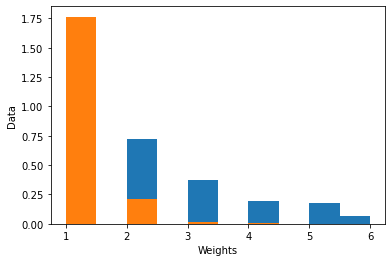

In [27]:
plt.hist(Y_gold_tf, density=True, bins=10)  # density=False would make counts


plt.hist(Y_pred_tf, density=True, bins=10)  # density=False would make counts
plt.ylabel('Data')
plt.xlabel('Weights');

In [111]:
print(classification_report(Y_gold_tf,Y_pred_tf))
print("Accuracy: %.2f"%accuracy_score(Y_gold_tf, Y_pred_tf))
cm = make_confusion_matrices(Y_gold_tf, Y_pred_tf, 1)
cm

              precision    recall  f1-score   support

           1       0.23      0.88      0.36      5955
           2       0.41      0.12      0.19      9461
           3       0.22      0.01      0.02      4926
           4       0.05      0.00      0.00      2571
           5       0.00      0.00      0.00      2360
           6       0.00      0.00      0.00       869

    accuracy                           0.25     26142
   macro avg       0.15      0.17      0.10     26142
weighted avg       0.25      0.25      0.15     26142

Accuracy: 0.25


array([[5265,  592,   64,   19,    9,    6],
       [8196, 1135,   95,   27,    4,    4],
       [4254,  603,   51,   11,    6,    1],
       [2358,  196,   12,    3,    1,    1],
       [2176,  172,    7,    3,    0,    2],
       [ 810,   56,    3,    0,    0,    0]])

# 5. Incorporating POS with Word Embedding in generating Word Importance 
The training algorithm that has been used to define the word vector is Continuous Bag of Words(CBOW).

Importance of various POS is subjective and depends on the application as well as the domain under consideration, it can be very useful to evaluate their importance even in a general setup. In this paper(http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.599.3242), researchers present a study to understand this importance. 

We have used 1st step of Neural Bag-of-word2. 

Composition(Summarizing word vectors) of word embedding may refer to semantic or syntactic meaning.


# 5.1 Building Word-Embedding using Word2Vec 


In [81]:
def build_vocabulary(all_words):
    word2vec = Word2Vec(all_words, min_count=2, size= wem_vector_size, workers=3, window = 10)
    vocabulary = word2vec.wv.vocab
    WV=np.zeros(shape=(len(vocabulary),wem_vector_size))
    count=0
    for voc in vocabulary.keys():
        WV[count] = word2vec.wv[voc]
        count = count + 1
    return (word2vec,vocabulary)


In [82]:
def build_pos_imp(vocabulary, all_words, pos_tagged):
    POS_IMP={}
    count=0
    for voc in vocabulary.keys():
        if voc in all_words[0]:
            for sent_pos in pos_tagged:
                for word, pos in sent_pos:
                    if word == voc:
                        POS_IMP[voc] = POS_IMPORTANCE.get(pos,2.5)
                        break
        else:
            POS_IMP[voc] = 2.5

        count=count+1
    return POS_IMP

In [83]:
def build_word_matrix(vocabulary, all_words, POS_IMP,word2vec):
    BOW=np.zeros(shape=(len(all_words),1))
    WV=np.zeros(shape=(len(all_words),wem_vector_size))
    POSA = np.zeros(shape=(len(all_words),1))
    count=0
    for word in all_words:
        if word in  vocabulary.keys():
            BOW[count] = [1.0]
            WV[count] = word2vec.wv[word]
            POSA[count] = [POS_IMP[word]]
        else:
            BOW[count] = [0]
        count=count+1

    return (BOW, WV, POSA)

In [84]:
def NormalizeData(data):
#     print("data::",data)
    min_v = 0.01
    max_v = 0
    for sentence_score in data:
        for words_score in sentence_score:
                min_v = min(min_v, words_score)
                max_v = max(max_v, words_score)
    data = [(x-min_v)/(max_v-min_v) if len(x)>1 else [0] for x in data]
        
    return data


# 5.2 Performance Measure

In [85]:
WEM_MSE = 0
WEM_Accuracy = []
Y_gold_wm = [] 
Y_pred_wm = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [normalize_text(sent) for sent in corpus]
            pos_tagged = []
            for i in range(len(all_words)):
                all_words[i] = [w for w in word_tokenize(str(all_words[i]))]
                pos_tagged.append(pos_tag(all_words[i]))

            word2vec,vocabulary = build_vocabulary(all_words)
            WIMP = []
            for sentence in all_words:
                POS_IMP = build_pos_imp(vocabulary, sentence, pos_tagged)

                BOW, WV, POSA = build_word_matrix(vocabulary, sentence, POS_IMP, word2vec)
                A = BOW * WV * POSA
                WIMP_TEMP=[]
                for i in range(0,len(sentence)):
                    WIMP_TEMP.append(np.mean(A[i]))
                    WIMP.append(WIMP_TEMP)

            WIMP = NormalizeData(WIMP)
            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0
            for i in range(0,len(scores)):

                if len(WIMP[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_wm += make_scalar(scores[i], 0)
                    Y_pred_wm += make_scalar(WIMP[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(WIMP[i][j]), float(scores[i][j])):
                            correct = correct +1
                            WEM_MSE = WEM_MSE + pow((float(WIMP[i][j])-float(scores[i][j])),2)

            accuracy = correct/total
            WEM_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(WEM_Accuracy))+"/44: Accuracy %.2f"%accuracy)

print("MSE: ", str(WEM_MSE))
       

W1208 09:54:54.322254 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:54.323143 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:54.323552 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:54.324129 140399148152640 word2vec.py:1405] collected 285 word types from a corpus of 1092 raw words and 73 sentences
I1208 09:54:54.324495 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:54.325105 140399148152640 word2vec.py:1480] effective_min_count=2 retains 135 unique words (47% of original 285, drops 150)
I1208 09:54:54.325448 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 942 word corpus (86% of original 1092, drops 150)
I1208 09:54:54.326331 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 285 items
I1208 09:54:54.326695 140399148152640 word2vec.py:1550] sample=0.0

Document Processed- 1/44: Accuracy 0.19


I1208 09:54:54.636434 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:54.636863 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:54.637228 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 540 raw words (149 effective words) took 0.0s, 88716 effective words/s
I1208 09:54:54.639025 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:54.639488 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:54.639848 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:54.640188 140399148152640 base_any2vec.py:1330] EPOCH - 2 : training on 540 raw words (138 effective words) took 0.0s, 94106 effective words/s
I1208 09:54:54.641876 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 m

Document Processed- 2/44: Accuracy 0.21


I1208 09:54:54.901003 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:54.901419 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:54.901873 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:54.902224 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 678 raw words (207 effective words) took 0.0s, 134907 effective words/s
I1208 09:54:54.903932 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:54.904336 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:54.904777 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:54.905130 140399148152640 base_any2vec.py:1330] EPOCH - 2 : training on 678 raw words (198 effective words) took 0.0s, 130752 effe

Document Processed- 3/44: Accuracy 0.16


W1208 09:54:55.264873 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:55.265591 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:55.265990 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:55.266612 140399148152640 word2vec.py:1405] collected 356 word types from a corpus of 1421 raw words and 128 sentences
I1208 09:54:55.266988 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:55.267647 140399148152640 word2vec.py:1480] effective_min_count=2 retains 169 unique words (47% of original 356, drops 187)
I1208 09:54:55.268014 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 1234 word corpus (86% of original 1421, drops 187)
I1208 09:54:55.268981 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 356 items
I1208 09:54:55.269342 140399148152640 word2vec.py:1550] sample=0

Document Processed- 4/44: Accuracy 0.75
Document Processed- 5/44: Accuracy 0.30


W1208 09:54:55.676004 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:55.676728 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:55.677112 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:55.677599 140399148152640 word2vec.py:1405] collected 238 word types from a corpus of 706 raw words and 64 sentences
I1208 09:54:55.677999 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:55.678518 140399148152640 word2vec.py:1480] effective_min_count=2 retains 100 unique words (42% of original 238, drops 138)
I1208 09:54:55.678864 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 568 word corpus (80% of original 706, drops 138)
I1208 09:54:55.679672 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 238 items
I1208 09:54:55.680044 140399148152640 word2vec.py:1550] sample=0.001

Document Processed- 6/44: Accuracy 0.75


I1208 09:54:55.958442 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:55.958948 140399148152640 word2vec.py:1405] collected 175 word types from a corpus of 489 raw words and 94 sentences
I1208 09:54:55.959292 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:55.959785 140399148152640 word2vec.py:1480] effective_min_count=2 retains 74 unique words (42% of original 175, drops 101)
I1208 09:54:55.960139 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 388 word corpus (79% of original 489, drops 101)
I1208 09:54:55.960835 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 175 items
I1208 09:54:55.961191 140399148152640 word2vec.py:1550] sample=0.001 downsamples 74 most-common words
I1208 09:54:55.961519 140399148152640 word2vec.py:1551] downsampling leaves estimated 123 word corpus (32.0% of prior 388)
I1208 09:54:55.962019 140399148152640 base_any2vec.py:1006] estimate

Document Processed- 7/44: Accuracy 0.62


W1208 09:54:56.315981 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:56.316710 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:56.317107 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:56.317665 140399148152640 word2vec.py:1405] collected 278 word types from a corpus of 1046 raw words and 127 sentences
I1208 09:54:56.318055 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:56.318656 140399148152640 word2vec.py:1480] effective_min_count=2 retains 141 unique words (50% of original 278, drops 137)
I1208 09:54:56.319012 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 909 word corpus (86% of original 1046, drops 137)
I1208 09:54:56.319919 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 278 items
I1208 09:54:56.320295 140399148152640 word2vec.py:1550] sample=0.

Document Processed- 8/44: Accuracy 0.36


W1208 09:54:56.668441 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:56.669203 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:56.669579 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:56.670130 140399148152640 word2vec.py:1405] collected 288 word types from a corpus of 905 raw words and 98 sentences
I1208 09:54:56.670496 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:56.671109 140399148152640 word2vec.py:1480] effective_min_count=2 retains 140 unique words (48% of original 288, drops 148)
I1208 09:54:56.671449 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 757 word corpus (83% of original 905, drops 148)
I1208 09:54:56.672538 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 288 items
I1208 09:54:56.672905 140399148152640 word2vec.py:1550] sample=0.001

Document Processed- 9/44: Accuracy 0.56


I1208 09:54:56.978436 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:56.978829 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:56.979326 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:56.979665 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 762 raw words (261 effective words) took 0.0s, 167901 effective words/s
I1208 09:54:56.981400 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:56.981806 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:56.982295 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:56.982623 140399148152640 base_any2vec.py:1330] EPOCH - 2 : training on 762 raw words (276 effective words) took 0.0s, 177924 effe

Document Processed- 10/44: Accuracy 0.32


I1208 09:54:57.232054 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:57.232504 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:57.232864 140399148152640 base_any2vec.py:1330] EPOCH - 5 : training on 781 raw words (281 effective words) took 0.0s, 169982 effective words/s
I1208 09:54:57.233222 140399148152640 base_any2vec.py:1366] training on a 3905 raw words (1323 effective words) took 0.0s, 91692 effective words/s
W1208 09:54:57.233554 140399148152640 base_any2vec.py:1371] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
W1208 09:54:57.449841 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:57.450572 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:57.450973 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, proce

Document Processed- 11/44: Accuracy 0.38


I1208 09:54:57.480665 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:57.481143 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:57.481507 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:57.481861 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 584 raw words (156 effective words) took 0.0s, 105839 effective words/s
I1208 09:54:57.483576 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:57.484095 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:57.484448 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:57.484798 140399148152640 base_any2vec.py:1330] EPOCH - 2 : training on 584 raw words (185 effective words) took 0.0s, 122398 effe

Document Processed- 12/44: Accuracy 0.29


I1208 09:54:57.725641 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:57.726029 140399148152640 base_any2vec.py:1330] EPOCH - 3 : training on 688 raw words (210 effective words) took 0.0s, 126285 effective words/s
I1208 09:54:57.727730 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:57.728130 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:57.728562 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:57.728912 140399148152640 base_any2vec.py:1330] EPOCH - 4 : training on 688 raw words (238 effective words) took 0.0s, 158390 effective words/s
I1208 09:54:57.730613 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:57.731176 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1

Document Processed- 13/44: Accuracy 0.22


W1208 09:54:58.128223 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:58.128985 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:58.129372 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:58.129803 140399148152640 word2vec.py:1405] collected 118 word types from a corpus of 305 raw words and 66 sentences
I1208 09:54:58.130179 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:58.130624 140399148152640 word2vec.py:1480] effective_min_count=2 retains 59 unique words (50% of original 118, drops 59)
I1208 09:54:58.131009 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 246 word corpus (80% of original 305, drops 59)
I1208 09:54:58.131615 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 118 items
I1208 09:54:58.131978 140399148152640 word2vec.py:1550] sample=0.001 do

Document Processed- 14/44: Accuracy 0.07
Document Processed- 15/44: Accuracy 0.13


W1208 09:54:58.319468 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:58.320218 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:58.320605 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:58.321064 140399148152640 word2vec.py:1405] collected 167 word types from a corpus of 377 raw words and 63 sentences
I1208 09:54:58.321430 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:58.321908 140399148152640 word2vec.py:1480] effective_min_count=2 retains 67 unique words (40% of original 167, drops 100)
I1208 09:54:58.322257 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 277 word corpus (73% of original 377, drops 100)
I1208 09:54:58.322912 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 167 items
I1208 09:54:58.323293 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 16/44: Accuracy 0.29


W1208 09:54:58.779432 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:58.780199 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:58.780583 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:58.781090 140399148152640 word2vec.py:1405] collected 164 word types from a corpus of 520 raw words and 82 sentences
I1208 09:54:58.781452 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:58.781951 140399148152640 word2vec.py:1480] effective_min_count=2 retains 75 unique words (45% of original 164, drops 89)
I1208 09:54:58.782302 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 431 word corpus (82% of original 520, drops 89)
I1208 09:54:58.782984 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 164 items
I1208 09:54:58.783329 140399148152640 word2vec.py:1550] sample=0.001 do

Document Processed- 17/44: Accuracy 0.32


I1208 09:54:58.804241 140399148152640 base_any2vec.py:1192] training model with 3 workers on 75 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
I1208 09:54:58.805896 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:58.806366 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:58.806733 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:54:58.807074 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 520 raw words (134 effective words) took 0.0s, 91553 effective words/s
I1208 09:54:58.808781 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:54:58.809261 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:54:58.809614 140399148152640 base_any2vec.py:348] worker thread finished; awa

Document Processed- 18/44: Accuracy 0.44


W1208 09:54:59.216244 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:59.217012 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:59.217410 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:59.217896 140399148152640 word2vec.py:1405] collected 207 word types from a corpus of 616 raw words and 56 sentences
I1208 09:54:59.218275 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:59.218798 140399148152640 word2vec.py:1480] effective_min_count=2 retains 93 unique words (44% of original 207, drops 114)
I1208 09:54:59.219150 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 502 word corpus (81% of original 616, drops 114)
I1208 09:54:59.219933 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 207 items
I1208 09:54:59.220293 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 19/44: Accuracy 0.24


W1208 09:54:59.437757 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:59.438487 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:59.438883 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:59.439365 140399148152640 word2vec.py:1405] collected 227 word types from a corpus of 566 raw words and 59 sentences
I1208 09:54:59.439718 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:59.440242 140399148152640 word2vec.py:1480] effective_min_count=2 retains 90 unique words (39% of original 227, drops 137)
I1208 09:54:59.440580 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 429 word corpus (75% of original 566, drops 137)
I1208 09:54:59.441346 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 227 items
I1208 09:54:59.441723 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 20/44: Accuracy 0.30


W1208 09:54:59.634703 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:59.635573 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:59.635962 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:59.636441 140399148152640 word2vec.py:1405] collected 222 word types from a corpus of 630 raw words and 44 sentences
I1208 09:54:59.636806 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:59.637336 140399148152640 word2vec.py:1480] effective_min_count=2 retains 92 unique words (41% of original 222, drops 130)
I1208 09:54:59.637708 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 500 word corpus (79% of original 630, drops 130)
I1208 09:54:59.638493 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 222 items
I1208 09:54:59.638872 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 21/44: Accuracy 0.24
Document Processed- 22/44: Accuracy 1.00


W1208 09:54:59.981158 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:54:59.981895 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:54:59.982294 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:54:59.982811 140399148152640 word2vec.py:1405] collected 226 word types from a corpus of 711 raw words and 124 sentences
I1208 09:54:59.983187 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:54:59.983726 140399148152640 word2vec.py:1480] effective_min_count=2 retains 100 unique words (44% of original 226, drops 126)
I1208 09:54:59.984075 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 585 word corpus (82% of original 711, drops 126)
I1208 09:54:59.984878 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 226 items
I1208 09:54:59.985247 140399148152640 word2vec.py:1550] sample=0.00

Document Processed- 23/44: Accuracy 0.18


W1208 09:55:00.269718 140399148152640 base_any2vec.py:1371] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
W1208 09:55:00.492730 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:00.493457 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:00.493842 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Document Processed- 24/44: Accuracy 0.40


I1208 09:55:00.494322 140399148152640 word2vec.py:1405] collected 180 word types from a corpus of 451 raw words and 94 sentences
I1208 09:55:00.494742 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:00.495269 140399148152640 word2vec.py:1480] effective_min_count=2 retains 72 unique words (40% of original 180, drops 108)
I1208 09:55:00.495607 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 343 word corpus (76% of original 451, drops 108)
I1208 09:55:00.496292 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 180 items
I1208 09:55:00.496637 140399148152640 word2vec.py:1550] sample=0.001 downsamples 72 most-common words
I1208 09:55:00.496991 140399148152640 word2vec.py:1551] downsampling leaves estimated 108 word corpus (31.7% of prior 343)
I1208 09:55:00.497461 140399148152640 base_any2vec.py:1006] estimated required memory for 72 words and 50 dimensions: 64800 bytes
I1208 09:55:00.497807 140399148152640 word2vec.py:1699] rese

Document Processed- 25/44: Accuracy 0.45


W1208 09:55:00.796694 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:00.797465 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:00.797874 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:00.798355 140399148152640 word2vec.py:1405] collected 169 word types from a corpus of 526 raw words and 115 sentences
I1208 09:55:00.798736 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:00.799225 140399148152640 word2vec.py:1480] effective_min_count=2 retains 72 unique words (42% of original 169, drops 97)
I1208 09:55:00.799560 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 429 word corpus (81% of original 526, drops 97)
I1208 09:55:00.800250 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 169 items
I1208 09:55:00.800616 140399148152640 word2vec.py:1550] sample=0.001 d

Document Processed- 26/44: Accuracy 0.16
Document Processed- 27/44: Accuracy 0.29


W1208 09:55:01.136276 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:01.137008 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:01.137397 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:01.137853 140399148152640 word2vec.py:1405] collected 175 word types from a corpus of 396 raw words and 87 sentences
I1208 09:55:01.138213 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:01.138698 140399148152640 word2vec.py:1480] effective_min_count=2 retains 68 unique words (38% of original 175, drops 107)
I1208 09:55:01.139079 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 289 word corpus (72% of original 396, drops 107)
I1208 09:55:01.139752 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 175 items
I1208 09:55:01.140130 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 28/44: Accuracy 0.78


W1208 09:55:01.461332 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:01.462080 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:01.462460 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:01.463089 140399148152640 word2vec.py:1405] collected 406 word types from a corpus of 1336 raw words and 99 sentences
I1208 09:55:01.463475 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:01.464162 140399148152640 word2vec.py:1480] effective_min_count=2 retains 172 unique words (42% of original 406, drops 234)
I1208 09:55:01.464513 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 1102 word corpus (82% of original 1336, drops 234)
I1208 09:55:01.465514 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 406 items
I1208 09:55:01.465878 140399148152640 word2vec.py:1550] sample=0.

Document Processed- 29/44: Accuracy 0.15


W1208 09:55:01.870771 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:01.871538 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:01.871950 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:01.872472 140399148152640 word2vec.py:1405] collected 270 word types from a corpus of 817 raw words and 122 sentences
I1208 09:55:01.872824 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:01.873410 140399148152640 word2vec.py:1480] effective_min_count=2 retains 125 unique words (46% of original 270, drops 145)
I1208 09:55:01.873755 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 672 word corpus (82% of original 817, drops 145)
I1208 09:55:01.874668 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 270 items
I1208 09:55:01.875043 140399148152640 word2vec.py:1550] sample=0.00

Document Processed- 30/44: Accuracy 0.18


W1208 09:55:02.221791 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:02.222530 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:02.222919 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:02.223381 140399148152640 word2vec.py:1405] collected 100 word types from a corpus of 281 raw words and 130 sentences
I1208 09:55:02.223740 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:02.224175 140399148152640 word2vec.py:1480] effective_min_count=2 retains 42 unique words (42% of original 100, drops 58)
I1208 09:55:02.224503 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 223 word corpus (79% of original 281, drops 58)
I1208 09:55:02.225049 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 100 items
I1208 09:55:02.225391 140399148152640 word2vec.py:1550] sample=0.001 d

Document Processed- 31/44: Accuracy 0.39
Document Processed- 32/44: Accuracy 0.19


W1208 09:55:02.544425 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:02.545172 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:02.545532 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:02.546008 140399148152640 word2vec.py:1405] collected 197 word types from a corpus of 564 raw words and 38 sentences
I1208 09:55:02.546354 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:02.546864 140399148152640 word2vec.py:1480] effective_min_count=2 retains 78 unique words (39% of original 197, drops 119)
I1208 09:55:02.547223 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 445 word corpus (78% of original 564, drops 119)
I1208 09:55:02.547924 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 197 items
I1208 09:55:02.548290 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 33/44: Accuracy 0.23


W1208 09:55:02.986951 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:02.987700 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:02.988092 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:02.988533 140399148152640 word2vec.py:1405] collected 185 word types from a corpus of 404 raw words and 69 sentences
I1208 09:55:02.988888 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:02.989389 140399148152640 word2vec.py:1480] effective_min_count=2 retains 69 unique words (37% of original 185, drops 116)
I1208 09:55:02.989721 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 288 word corpus (71% of original 404, drops 116)
I1208 09:55:02.990392 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 185 items
I1208 09:55:02.990746 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 34/44: Accuracy 0.31


W1208 09:55:03.169615 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:03.170376 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:03.170768 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:03.171252 140399148152640 word2vec.py:1405] collected 239 word types from a corpus of 645 raw words and 44 sentences
I1208 09:55:03.171607 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:03.172169 140399148152640 word2vec.py:1480] effective_min_count=2 retains 95 unique words (39% of original 239, drops 144)
I1208 09:55:03.172509 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 501 word corpus (77% of original 645, drops 144)
I1208 09:55:03.173305 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 239 items
I1208 09:55:03.173655 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 35/44: Accuracy 0.13


W1208 09:55:03.393057 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:03.393767 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:03.394153 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:03.394634 140399148152640 word2vec.py:1405] collected 225 word types from a corpus of 662 raw words and 58 sentences
I1208 09:55:03.394996 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:03.395530 140399148152640 word2vec.py:1480] effective_min_count=2 retains 104 unique words (46% of original 225, drops 121)
I1208 09:55:03.395877 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 541 word corpus (81% of original 662, drops 121)
I1208 09:55:03.396722 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 225 items
I1208 09:55:03.397089 140399148152640 word2vec.py:1550] sample=0.001

Document Processed- 36/44: Accuracy 0.14


W1208 09:55:03.613608 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:03.614343 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:03.614730 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:03.615229 140399148152640 word2vec.py:1405] collected 244 word types from a corpus of 686 raw words and 50 sentences
I1208 09:55:03.615571 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:03.616127 140399148152640 word2vec.py:1480] effective_min_count=2 retains 102 unique words (41% of original 244, drops 142)
I1208 09:55:03.616463 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 544 word corpus (79% of original 686, drops 142)
I1208 09:55:03.617366 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 244 items
I1208 09:55:03.617761 140399148152640 word2vec.py:1550] sample=0.001

Document Processed- 37/44: Accuracy 0.31
Document Processed- 38/44: Accuracy 0.15


W1208 09:55:03.907159 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:03.907876 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:03.908278 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:03.908783 140399148152640 word2vec.py:1405] collected 214 word types from a corpus of 631 raw words and 94 sentences
I1208 09:55:03.909149 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:03.909665 140399148152640 word2vec.py:1480] effective_min_count=2 retains 94 unique words (43% of original 214, drops 120)
I1208 09:55:03.910029 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 511 word corpus (80% of original 631, drops 120)
I1208 09:55:03.910807 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 214 items
I1208 09:55:03.911179 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 39/44: Accuracy 0.20


I1208 09:55:04.210570 140399148152640 base_any2vec.py:1192] training model with 3 workers on 99 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
I1208 09:55:04.213151 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:55:04.213629 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:55:04.214010 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:55:04.214365 140399148152640 base_any2vec.py:1330] EPOCH - 1 : training on 570 raw words (171 effective words) took 0.0s, 112563 effective words/s
I1208 09:55:04.216089 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:55:04.216498 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:55:04.216932 140399148152640 base_any2vec.py:348] worker thread finished; aw

Document Processed- 40/44: Accuracy 0.18
Document Processed- 41/44: Accuracy 0.41


W1208 09:55:04.558401 140399148152640 base_any2vec.py:720] consider setting layer size to a multiple of 4 for greater performance
I1208 09:55:04.559124 140399148152640 word2vec.py:1399] collecting all words and their counts
I1208 09:55:04.559499 140399148152640 word2vec.py:1382] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
I1208 09:55:04.559968 140399148152640 word2vec.py:1405] collected 177 word types from a corpus of 455 raw words and 56 sentences
I1208 09:55:04.560339 140399148152640 word2vec.py:1458] Loading a fresh vocabulary
I1208 09:55:04.560822 140399148152640 word2vec.py:1480] effective_min_count=2 retains 70 unique words (39% of original 177, drops 107)
I1208 09:55:04.561169 140399148152640 word2vec.py:1486] effective_min_count=2 leaves 348 word corpus (76% of original 455, drops 107)
I1208 09:55:04.561902 140399148152640 word2vec.py:1547] deleting the raw counts dictionary of 177 items
I1208 09:55:04.562297 140399148152640 word2vec.py:1550] sample=0.001 

Document Processed- 42/44: Accuracy 0.20


I1208 09:55:04.821373 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:55:04.821829 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:55:04.822172 140399148152640 base_any2vec.py:1330] EPOCH - 2 : training on 584 raw words (185 effective words) took 0.0s, 112193 effective words/s
I1208 09:55:04.823879 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2 more threads
I1208 09:55:04.824405 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 1 more threads
I1208 09:55:04.824788 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 0 more threads
I1208 09:55:04.825137 140399148152640 base_any2vec.py:1330] EPOCH - 3 : training on 584 raw words (159 effective words) took 0.0s, 102176 effective words/s
I1208 09:55:04.826809 140399148152640 base_any2vec.py:348] worker thread finished; awaiting finish of 2

Document Processed- 43/44: Accuracy 0.18
Document Processed- 44/44: Accuracy 0.67
MSE:  1.157876795416127


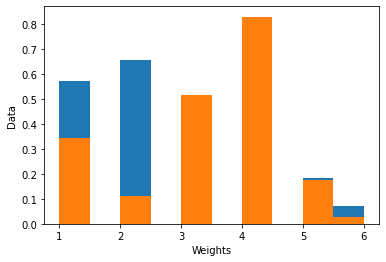

In [86]:
plt.hist(Y_gold_wm, density=True, bins=10)  # density=False would make counts
plt.hist(Y_pred_wm, density=True, bins=10)

plt.ylabel('Data')
plt.xlabel('Weights');

In [87]:
print(classification_report(Y_gold_wm,Y_pred_wm))
print("Accuracy: %.2f"%accuracy_score(Y_gold_wm, Y_pred_wm))
cm = make_confusion_matrices(Y_gold_wm, Y_pred_wm, 1)
cm

              precision    recall  f1-score   support

           1       0.76      0.45      0.57       328
           2       0.33      0.06      0.10       375
           3       0.15      0.24      0.19       184
           4       0.12      0.50      0.19       111
           5       0.09      0.08      0.09       106
           6       0.13      0.05      0.07        41

    accuracy                           0.25      1145
   macro avg       0.26      0.23      0.20      1145
weighted avg       0.38      0.25      0.25      1145

Accuracy: 0.25


array([[149,  13,  51,  90,  24,   1],
       [ 33,  21, 114, 163,  35,   9],
       [ 12,  13,  45,  97,  17,   0],
       [  0,  10,  32,  56,  12,   1],
       [  2,   6,  33,  54,   9,   2],
       [  0,   0,  21,  15,   3,   2]])

# 6. Context-aware Term Weight Determination Using BERT

Prior work has shown that these embeddings can characterize a token’s syntactic features (e.g., word dependencies) and semantic features (e.g., named entity labeling), which can help estimate a term’s importance. Here, the contextualized token embeddings have been fed into a linear layer. It maps a token’s embedding into a real-number weight.

http://www.cs.cmu.edu/~zhuyund/Zhuyun_Dai_Dissertation.pdf

https://www.cs.cmu.edu/~callan/Papers/TheWebConf20-Zhuyun-Dai.pdf


In [88]:
# Loading pre-trained BERT Base
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True,)

#Use evaluation mode
model.eval()

I1208 09:55:27.854806 140399148152640 configuration_utils.py:283] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/aa7510/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I1208 09:55:27.855630 140399148152640 configuration_utils.py:319] Model config BertConfig {
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id"

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [89]:
def BERT_Embedding(text):
    marked_text = "[CLS] " + text + " [SEP]"

    # Tokenize text
    tokenized_text = tokenizer.tokenize(marked_text)
#     print("Length of tokenized text: " + str(len(tokenized_text)))

    # Map tokenized text to vocabulary indices
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

        # `output_hidden_states = True` so the 3rd element has the hidden states for each layer. 
        # More information at: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        hidden_states = outputs[2]
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    token_vecs_sum = []
    # `token_embeddings` is a [32 x 12 x 768] tensor, now for each token of 32:

    for token in token_embeddings:

        # `token` is a [12 x 768] tensor
        # Sum the vectors from the last four layers to represent the token.
        sum_vec = torch.sum(token[-4:], dim=0)
        token_vecs_sum.append(sum_vec)
    
    BERT_Word_Embedding = np.zeros(shape=(len(token_vecs_sum),len(token_vecs_sum[0])))
    for i in range(0, len(token_vecs_sum)):
        BERT_Word_Embedding[i] = token_vecs_sum[i].numpy()
#     print(BERT_Word_Embedding.shape)
    return BERT_Word_Embedding



# 6.1 Performance Measure

In [90]:
BERT_Accuracy = []
Y_gold_bert = []
Y_pred_bert = []
for typ in file_type:
    for key in folder.keys():
        for value in folder[key]:
            file = "./swb_ms98_transcriptions/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            wimp_file = "./wimp_corpus/annotations/"+key+"/"+value+"/sw"+value+typ+"-ms98-a-trans.text"
            corpus = get_sentence_list(file)

            all_words = [str(normalize_text(sent)) for sent in corpus]
            
    
            contextual_wimp_data=[]
            for text in all_words:
                sentence_mat = BERT_Embedding(text)
                WIMP_temp = []
                
                for word_emb in sentence_mat[1:-1]:
                    
                    word_emb = np.reshape(word_emb,(word_emb.size,1))

                    W = np.ones(shape=(len(word_emb),1))

                    X = np.dot(W.T,word_emb)+0.05
                    WIMP_temp.append(X[0][0])
                    
                    
                contextual_wimp_data.append(WIMP_temp)

            contextual_wimp_data = NormalizeData(contextual_wimp_data)

            scores = get_wimp_scores(wimp_file)
            total = 0 
            correct = 0

            for i in range(0,len(scores)):

                if len(contextual_wimp_data[i]) == len(scores[i]):
                    total = total + len(scores[i])
                    Y_gold_bert += make_scalar(scores[i], 0)
                    Y_pred_bert += make_scalar(contextual_wimp_data[i], 0)
                    for j in range(0,len(scores[i])):
                        if compare(float(contextual_wimp_data[i][j]), float(scores[i][j])):
                            correct = correct +1

            accuracy = correct/total
            BERT_Accuracy.append(accuracy)
            print("Document Processed- "+str(len(BERT_Accuracy))+"/44: Accuracy %.2f"%accuracy)

            
    

Document Processed- 1/44: Accuracy 0.42
Document Processed- 2/44: Accuracy 0.53
Document Processed- 3/44: Accuracy 0.44
Document Processed- 4/44: Accuracy 0.33
Document Processed- 5/44: Accuracy 0.43
Document Processed- 6/44: Accuracy 0.32
Document Processed- 7/44: Accuracy 0.49
Document Processed- 8/44: Accuracy 0.41
Document Processed- 9/44: Accuracy 0.34
Document Processed- 10/44: Accuracy 0.38
Document Processed- 11/44: Accuracy 0.31
Document Processed- 12/44: Accuracy 0.43
Document Processed- 13/44: Accuracy 0.34
Document Processed- 14/44: Accuracy 0.51
Document Processed- 15/44: Accuracy 0.58
Document Processed- 16/44: Accuracy 0.40
Document Processed- 17/44: Accuracy 0.43
Document Processed- 18/44: Accuracy 0.47
Document Processed- 19/44: Accuracy 0.37
Document Processed- 20/44: Accuracy 0.38
Document Processed- 21/44: Accuracy 0.41
Document Processed- 22/44: Accuracy 0.41
Document Processed- 23/44: Accuracy 0.37
Document Processed- 24/44: Accuracy 0.50
Document Processed- 25/44

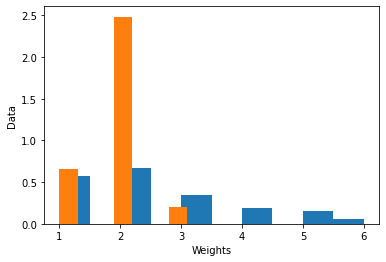

In [91]:
plt.hist(Y_gold_bert, density=True, bins=10)  # density=False would make counts
plt.hist(Y_pred_bert, density=True, bins=10)

plt.ylabel('Data')
plt.xlabel('Weights');

In [92]:
print(classification_report(Y_gold_bert,Y_pred_bert))
print("Accuracy: %.2f"%accuracy_score(Y_gold_bert, Y_pred_bert))
cm = make_confusion_matrices(Y_gold_bert, Y_pred_bert, 1)
cm

              precision    recall  f1-score   support

           1       0.66      0.45      0.53      3262
           2       0.36      0.81      0.50      3748
           3       0.14      0.05      0.07      1974
           4       0.00      0.00      0.00      1059
           5       0.00      0.00      0.00       897
           6       0.00      0.00      0.00       340

    accuracy                           0.41     11280
   macro avg       0.19      0.22      0.18     11280
weighted avg       0.34      0.41      0.33     11280

Accuracy: 0.41


/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1459, 1676,  123,    4,    0,    0],
       [ 369, 3046,  332,    1,    0,    0],
       [ 222, 1656,   96,    0,    0,    0],
       [  76,  946,   37,    0,    0,    0],
       [  66,  795,   36,    0,    0,    0],
       [  13,  288,   39,    0,    0,    0]])

# 7. Train BERT embeddings the Word Importance and Predict with Selected Classifier

Embeddings of more than 11,000 tokens(generated using BERT) along their corresponding importance weights have been stored in `Data.csv` file.
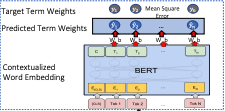

In [12]:
def load_data():
    X = np.loadtxt("Data.csv", delimiter=",")
    return X


In [13]:
def scale_data(y_data):
    y_all =[]
    for y in y_data:
        if 0 <= float(y) < 0.1:
            y_all.append(1);
        elif 0.1 <=  float(y) < 0.3:
            y_all.append(2);
        elif 0.3 <= float(y) < 0.5:
            y_all.append(3);
        elif 0.5 <= float(y) < 0.7:
            y_all.append(4);
        elif 0.7 <=  float(y) < 0.9:
            y_all.append(5);
        else:
            y_all.append(6);
    y_all = np.array(y_all)
    return y_all

In [14]:
X = load_data()
X_data = X[:,:-1]
y_data = X[:,-1]
y_data = scale_data(y_data)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, random_state=42)

In [15]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 7.1 Model Selection

In [16]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
print(entries)

KeyboardInterrupt: 

# 7.2 Predict with Logistic Regression Classifier

In [19]:
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

/.autofs/tools/spack/var/spack/environments/engl-581-2/.spack-env/view/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [20]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print(classification_report(y_test,y_pred))
cm = make_confusion_matrices(y_test, y_pred, 1)
cm

Mean Absolute Error: 0.49556737588652483
Mean Squared Error: 0.8643617021276596
Root Mean Squared Error: 0.9297105474972626
              precision    recall  f1-score   support

           1       0.69      0.72      0.71       464
           2       0.64      0.68      0.66       453
           3       0.48      0.38      0.42       145
           4       0.48      0.33      0.39        39
           5       0.40      0.29      0.33        21
           6       0.56      0.83      0.67         6

    accuracy                           0.64      1128
   macro avg       0.54      0.54      0.53      1128
weighted avg       0.63      0.64      0.63      1128



array([[336, 100,  21,   4,   3,   0],
       [105, 307,  29,   7,   2,   3],
       [ 28,  56,  55,   3,   3,   0],
       [ 10,  11,   3,  13,   1,   1],
       [  5,   5,   5,   0,   6,   0],
       [  0,   0,   1,   0,   0,   5]])

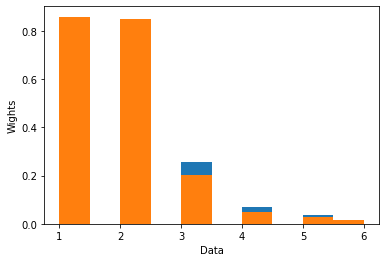

In [103]:
plt.hist(y_test, density=True, bins=10)  # density=False would make counts
plt.hist(y_pred, density=True, bins=10)  # density=False would make counts

plt.ylabel('Wights')
plt.xlabel('Data');